In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import linear_model, metrics, model_selection, preprocessing, ensemble
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import sparse
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import matplotlib.ticker as mtick

In [5]:
from plot_function import plot_randomforest

In [6]:
Ames = pd.read_csv('AmesFinalDB.csv')
Ames.drop(['Unnamed: 0'],axis=1,inplace=True)
Ames.head(3)

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Lot_Shape,Land_Contour,Lot_Config,Land_Slope,Neighborhood,Condition_1,...,Mo_Sold,Sale_Type,Sale_Condition,SalePrice,exterior,basement_type,basement_area,age,remodeled_age,garage_age
0,20,RL,141.0,31770,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,5,WD,Normal,215000,0,BLQ_Unf,639.0,50,0,50.0
1,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,6,WD,Normal,105000,VinylSd_VinylSd,Rec_LwQ,612.0,49,0,49.0
2,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,6,WD,Normal,172000,Wd Sdng_Wd Sdng,ALQ_Unf,923.0,52,0,52.0


In [7]:
print('Ames shape is : ', str(Ames.shape))

Ames shape is :  (2930, 59)


In [8]:
categorical_features = ['MS_SubClass','MS_Zoning','Lot_Shape','Land_Contour','Lot_Config','Land_Slope']
categorical_features.extend(['Neighborhood','Condition_1','Bldg_Type','House_Style','Roof_Style'])
categorical_features.extend(['Mas_Vnr_Type','Exter_Qual','Exter_Cond','Foundation','Bsmt_Qual','Bsmt_Exposure'])
categorical_features.extend(['basement_type','Heating_QC','Garage_Finish','Mo_Sold','Sale_Type','Sale_Condition','Kitchen_Qual'])
categorical_features.extend(['exterior','Fireplace_Qu','Garage_Type','Garage_Qual'])

Ordinal_featues = ['Overall_Qual','Overall_Cond','Bsmt_Full_Bath','Bsmt_Half_Bath','Bedroom_AbvGr','Full_Bath',
                  'Half_Bath','Kitchen_AbvGr','TotRms_AbvGrd','Fireplaces','Garage_Cars']

Continous_features = ['Lot_Frontage','Lot_Area','age','remodeled_age','Mas_Vnr_Area','basement_area']
Continous_features.extend(['Bsmt_Unf_SF','Total_Bsmt_SF','1st_Flr_SF','2nd_Flr_SF','Low_Qual_Fin_SF'])
Continous_features.extend(['Gr_Liv_Area'])              
Continous_features.extend(['Garage_Area'])
Continous_features.extend(['Wood_Deck_SF','Open_Porch_SF','Enclosed_Porch','Screen_Porch','Pool_Area'])
Continous_features.extend(['SalePrice','garage_age'])

In [9]:
X = Ames.drop(['SalePrice'],axis=1).copy()
Y = Ames.SalePrice.copy()

In [10]:
AmesFinal = X.drop(categorical_features,axis = 1).copy()
AmesData = AmesFinal.values
AmesCol = AmesFinal.columns

for ifeature in categorical_features:
    
    temp_df = pd.get_dummies(Ames.loc[:,ifeature], prefix = ifeature, prefix_sep = '_')
    AmesCol = list(AmesCol) + list(temp_df.columns)
    temp_data = temp_df.values
    AmesData = np.hstack([AmesData,temp_data])
    
AmesFinal = pd.DataFrame(AmesData, columns = AmesCol)

In [11]:
fitted_data, fitted_lambda = stats.boxcox(Y)
print('Lambda parameter is :', fitted_lambda)

Lambda parameter is : 0.007644244604190389


In [12]:
X = AmesFinal
Y = fitted_data

In [13]:
Y_stratify = pd.cut(Y,bins = 10)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 144, stratify = Y_stratify)

In [15]:
print(np.min(Y))
print(np.max(Y))

9.80651043059859
14.25940038893919


In [16]:
RFR = ensemble.RandomForestRegressor()
RFR.set_params(n_estimators = 100, max_depth = 10, min_samples_leaf = 20)

RandomForestRegressor(max_depth=10, min_samples_leaf=20)

In [17]:
RFR.fit(X_train, Y_train)
R2_train = np.round(RFR.score(X_train,Y_train),3)
R2_test  = np.round(RFR.score(X_test,Y_test),3)
print('Training score is :'+ str(R2_train))
print('Testing  score is :'+ str(R2_test))

Training score is :0.884
Testing  score is :0.847


In [18]:
type(X)

pandas.core.frame.DataFrame

In [19]:
zip_data = zip(X.columns, RFR.feature_importances_)
sorted_features = sorted(zip_data,key = lambda x:x[1],reverse=True)
sorted_features_df = pd.DataFrame(sorted_features, columns = ['Feature','Score'])
sorted_features_df.head()

,Feature,Score
0,Overall_Qual,0.625690
1,Gr_Liv_Area,0.109102
2,Garage_Cars,0.060811
3,Total_Bsmt_SF,0.048464
4,Garage_Area,0.037061


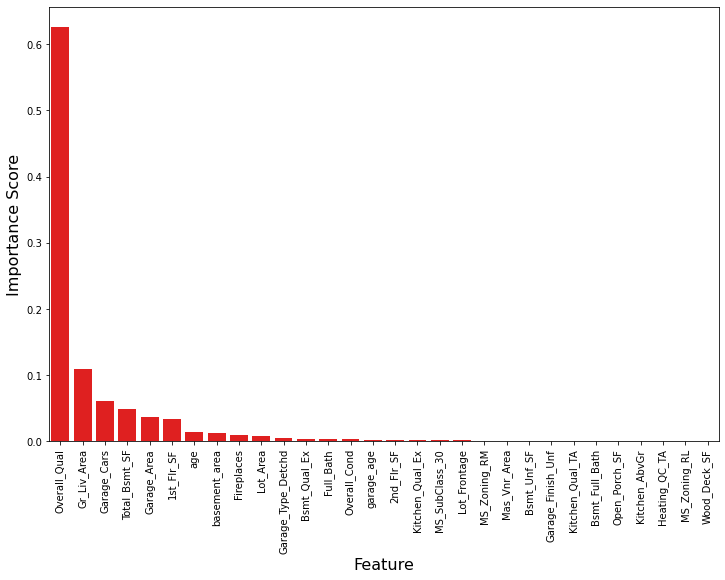

In [20]:
fig, axis = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data = sorted_features_df.iloc[:30,:], x = 'Feature', y = 'Score',ax = axis, color = 'red')
axis.set_xlabel('Feature',fontsize = 16)
axis.set_ylabel('Importance Score', fontsize = 16)
plt.xticks(rotation = 90);

In [21]:
y_train_err = RFR.predict(X_train) - Y_train
y_test_err  = RFR.predict(X_test)  - Y_test

In [40]:
y_err = RFR.predict(X) - Y

In [41]:
y_err_ratio = y_err / Y 

C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\1132930634.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_xticklabels(L, fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\1132930634.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_xticklabels(L, fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\1132930634.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\1132930634.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)


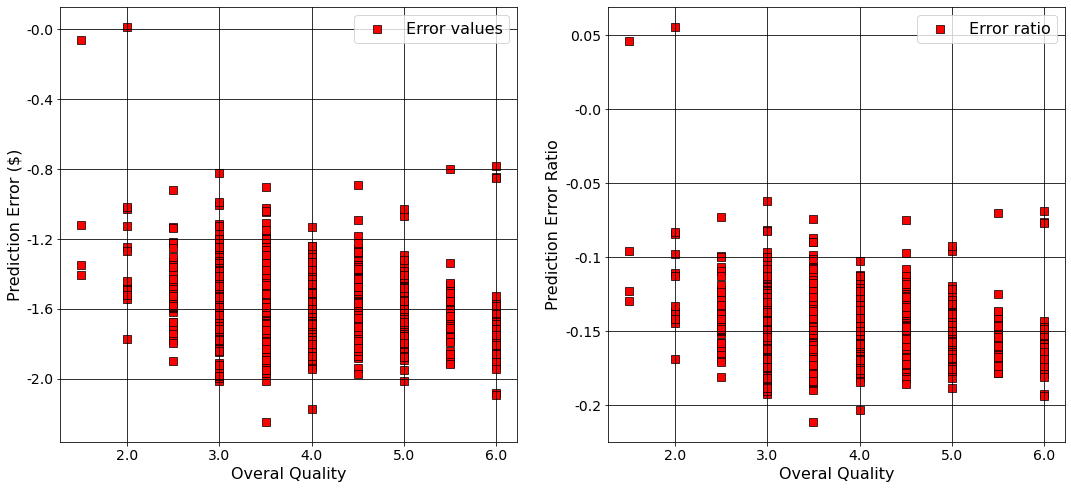

In [61]:
fig, axis = plt.subplots(1,2,figsize=(18,8))

sns.scatterplot(x =X.Overall_Qual.values, y = y_err, color = 'red', ax = axis[0], marker = 's',
                edgecolor = 'black', s=80, label = 'Error values')
sns.scatterplot(x =X.Overall_Qual.values, y = y_err_ratio, color = 'red', ax = axis[1], marker = 's',
                edgecolor = 'black', s=80, label = 'Error ratio')

axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')
axis[0].xaxis.grid(True,color='black')
axis[1].xaxis.grid(True,color='black')

axis[0].set_xlabel('Overal Quality',fontsize=16)
axis[0].set_ylabel('Prediction Error ($)',fontsize=16)
axis[1].set_xlabel('Overal Quality',fontsize=16)
axis[1].set_ylabel('Prediction Error Ratio',fontsize=16)

L =[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]
axis[0].set_xticklabels(L, fontsize = 14)
axis[1].set_xticklabels(L, fontsize = 14)

axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)

axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2486750649.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_xticklabels(np.round(np.arange(-1000,6000,1000),0), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2486750649.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_xticklabels(np.round(np.arange(-1000,6000,1000),0), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2486750649.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2486750649.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)


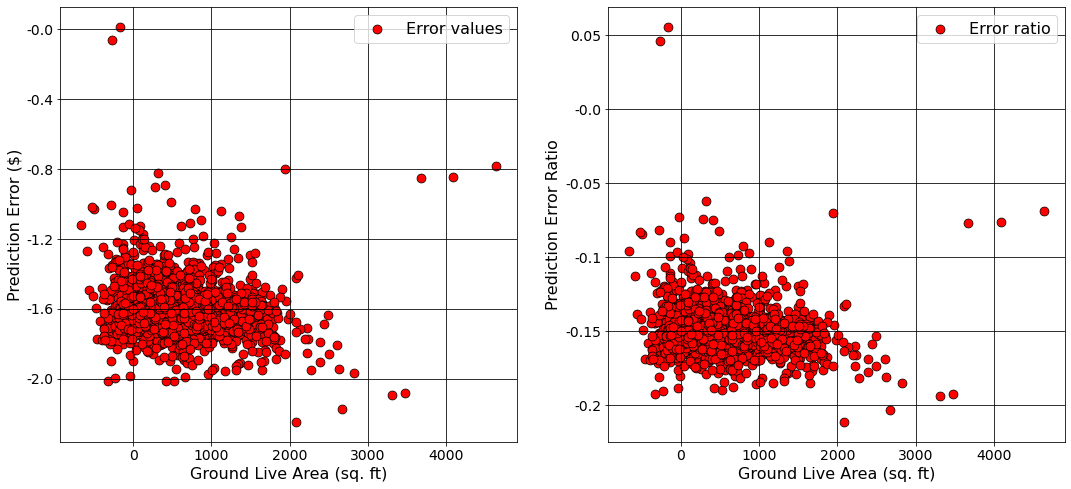

In [60]:
fig, axis = plt.subplots(1,2,figsize=(18,8))

sns.scatterplot(x =X.Gr_Liv_Area, y = y_err, color = 'red', ax = axis[0], marker = 'o',
                edgecolor = 'black', s=80, label = 'Error values')
sns.scatterplot(x =X.Gr_Liv_Area, y = y_err_ratio, color = 'red', ax = axis[1], marker = 'o',
                edgecolor = 'black', s=80, label = 'Error ratio')

axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')
axis[0].xaxis.grid(True,color='black')
axis[1].xaxis.grid(True,color='black')

axis[0].set_xlabel('Ground Live Area (sq. ft)',fontsize=16)
axis[0].set_ylabel('Prediction Error ($)',fontsize=16)
axis[1].set_xlabel('Ground Live Area (sq. ft)',fontsize=16)
axis[1].set_ylabel('Prediction Error Ratio',fontsize=16)

axis[0].set_xticklabels(np.round(np.arange(-1000,6000,1000),0), fontsize = 14)
axis[1].set_xticklabels(np.round(np.arange(-1000,6000,1000),0), fontsize = 14)

axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)

axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2413173328.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_xticklabels(L, fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2413173328.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_xticklabels(L, fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2413173328.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2413173328.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)


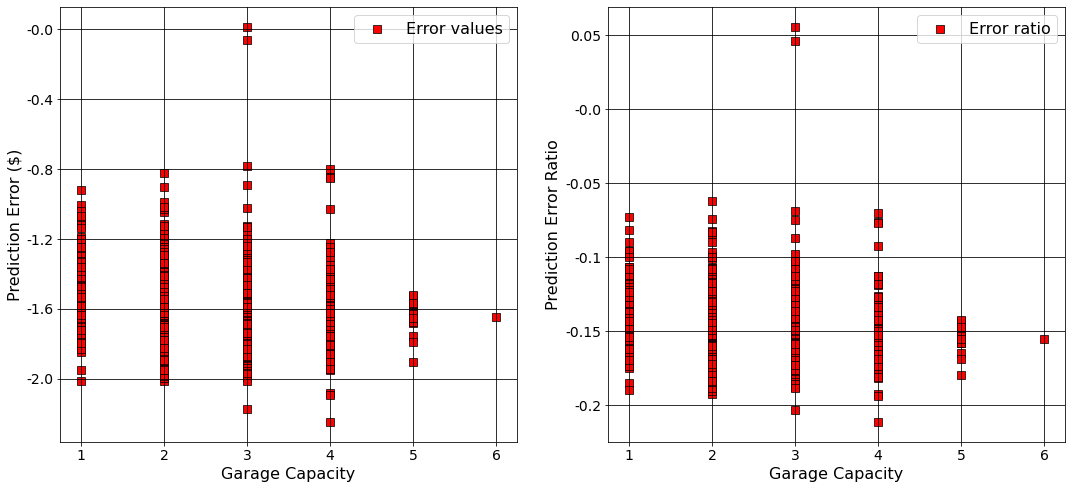

In [64]:
fig, axis = plt.subplots(1,2,figsize=(18,8))

sns.scatterplot(x =X.Garage_Cars.values, y = y_err, color = 'red', ax = axis[0], marker = 's',
                edgecolor = 'black', s=80, label = 'Error values')
sns.scatterplot(x =X.Garage_Cars.values, y = y_err_ratio, color = 'red', ax = axis[1], marker = 's',
                edgecolor = 'black', s=80, label = 'Error ratio')

axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')
axis[0].xaxis.grid(True,color='black')
axis[1].xaxis.grid(True,color='black')

axis[0].set_xlabel('Garage Capacity',fontsize=16)
axis[0].set_ylabel('Prediction Error ($)',fontsize=16)
axis[1].set_xlabel('Garage Capacity',fontsize=16)
axis[1].set_ylabel('Prediction Error Ratio',fontsize=16)

L =[ 0,  1,  2,  3, 4, 5, 6]
axis[0].set_xticklabels(L, fontsize = 14)
axis[1].set_xticklabels(L, fontsize = 14)

axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)

axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2909724339.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_xticklabels(np.round(np.arange(-500,4000,500),0), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2909724339.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_xticklabels(np.round(np.arange(-500,4000,500),0), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2909724339.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2909724339.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)


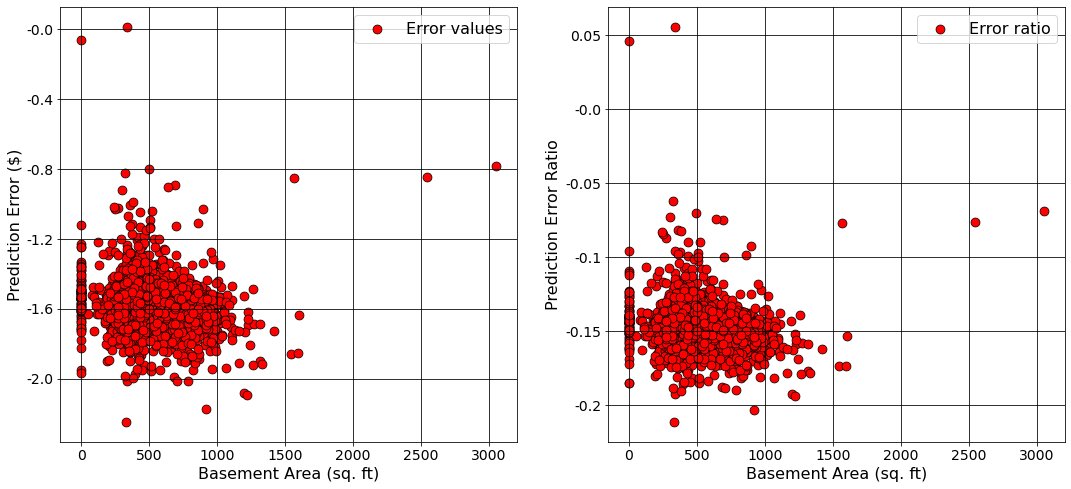

In [67]:
fig, axis = plt.subplots(1,2,figsize=(18,8))

sns.scatterplot(x =X.Total_Bsmt_SF, y = y_err, color = 'red', ax = axis[0], marker = 'o',
                edgecolor = 'black', s=80, label = 'Error values')
sns.scatterplot(x =X.Total_Bsmt_SF, y = y_err_ratio, color = 'red', ax = axis[1], marker = 'o',
                edgecolor = 'black', s=80, label = 'Error ratio')

axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')
axis[0].xaxis.grid(True,color='black')
axis[1].xaxis.grid(True,color='black')

axis[0].set_xlabel('Basement Area (sq. ft)',fontsize=16)
axis[0].set_ylabel('Prediction Error ($)',fontsize=16)
axis[1].set_xlabel('Basement Area (sq. ft)',fontsize=16)
axis[1].set_ylabel('Prediction Error Ratio',fontsize=16)

axis[0].set_xticklabels(np.round(np.arange(-500,4000,500),0), fontsize = 14)
axis[1].set_xticklabels(np.round(np.arange(-500,4000,500),0), fontsize = 14)

axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)

axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2893972613.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_xticklabels(np.round(np.arange(-200,1600,200),0), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2893972613.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_xticklabels(np.round(np.arange(-200,1600,200),0), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2893972613.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
C:\Users\behroozk\AppData\Local\Temp\ipykernel_23580\2893972613.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)


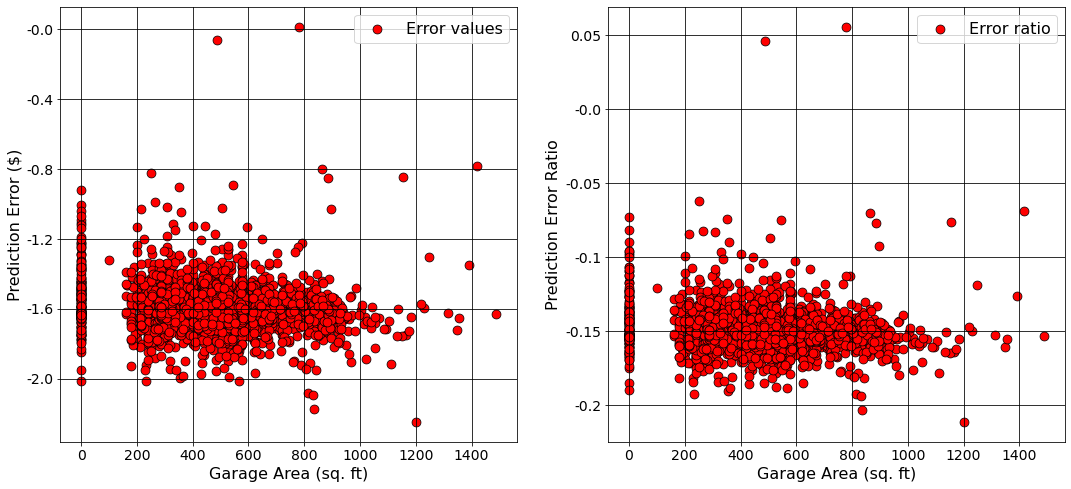

In [69]:
fig, axis = plt.subplots(1,2,figsize=(18,8))

sns.scatterplot(x =X.Garage_Area, y = y_err, color = 'red', ax = axis[0], marker = 'o',
                edgecolor = 'black', s=80, label = 'Error values')
sns.scatterplot(x =X.Garage_Area, y = y_err_ratio, color = 'red', ax = axis[1], marker = 'o',
                edgecolor = 'black', s=80, label = 'Error ratio')

axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')
axis[0].xaxis.grid(True,color='black')
axis[1].xaxis.grid(True,color='black')

axis[0].set_xlabel('Garage Area (sq. ft)',fontsize=16)
axis[0].set_ylabel('Prediction Error ($)',fontsize=16)
axis[1].set_xlabel('Garage Area (sq. ft)',fontsize=16)
axis[1].set_ylabel('Prediction Error Ratio',fontsize=16)

axis[0].set_xticklabels(np.round(np.arange(-200,1600,200),0), fontsize = 14)
axis[1].set_xticklabels(np.round(np.arange(-200,1600,200),0), fontsize = 14)

axis[0].set_yticklabels(np.round(np.arange(-2.4,2.4,0.4),3), fontsize = 14)
axis[1].set_yticklabels(np.round(np.arange(-0.25,0.25,.05),3), fontsize = 14)

axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

In [ ]:
#Study based on neighborhood
X_train.columns

In [ ]:
np.unique(Ames.Neighborhood)

In [ ]:
neighs = []
for ineigh in np.unique(Ames.Neighborhood):
    st = 'Neighborhood'+'_'+ineigh
    neighs.append(st)

In [ ]:
neigh_score_train = []
neigh_score_test  = []
neigh_str = []
for ineigh in neighs:
    x_temp_train = X_train.loc[X_train[ineigh]==1,:]
    y_temp_train = Y_train[X_train[ineigh]==1]
    x_temp_test  = X_test.loc[X_test[ineigh]==1,:]
    y_temp_test  = Y_test[X_test[ineigh]==1]
    if ((x_temp_train.shape[0]==0)|(x_temp_test.shape[0]==0)):
        continue
    r2_train = np.round(RFR.score(x_temp_train,y_temp_train),3)
    r2_test  = np.round(RFR.score(x_temp_test,y_temp_test),3)
    neigh_score_train.append(r2_train)
    neigh_score_test.append(r2_test)
    neigh_str.append(ineigh.split('_')[1])
    #print(str(r2_train) + ' '+str(r2_test))

In [ ]:
df = pd.DataFrame(data = neigh_str, columns=['Neighborhood'])
df['R2_train'] = list(map(lambda x:abs(x),neigh_score_train))
df['R2_test']  = list(map(lambda x:abs(x),neigh_score_test))
fig, axis = plt.subplots(1,2,figsize=(18,8))
sns.barplot(data = df, x ='Neighborhood', y = 'R2_train', color = 'blue', ax = axis[0],label='Train')
sns.barplot(data = df, x ='Neighborhood', y = 'R2_test', color = 'red', ax = axis[1],label='Test')
axis[0].set_ylim(0,1)
axis[1].set_ylim(0,1)
axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')
axis[0].set_xlabel('Neighborhood',fontsize=16)
axis[0].set_ylabel('Score',fontsize=16)
axis[1].set_xlabel('Neighborhood',fontsize=16)
axis[1].set_ylabel('Score',fontsize=16)
axis[0].set_xticklabels(axis[0].get_xticklabels(), fontsize = 14,rotation=90)
axis[1].set_xticklabels(axis[1].get_xticklabels(), fontsize = 14,rotation=90)
axis[0].set_yticklabels( labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14)
axis[1].set_yticklabels( labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14)
axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

It seems that "BrDale", "Edwards", "Greens", "Veenker" are not very good

In [ ]:
len1 = Ames.loc[Ames['Neighborhood']=='BrDale',:].shape[0]
print('Number of samples for Neighborhood = BrDale is :' + str(len1))
len2 = Ames.loc[Ames['Neighborhood']=='Edwards',:].shape[0]
print('Number of samples for Neighborhood = Edwards is :' + str(len2))
len3 = Ames.loc[Ames['Neighborhood']=='Greens',:].shape[0]
print('Number of samples for Neighborhood = Greens is :' + str(len3))
len4 = Ames.loc[Ames['Neighborhood']=='Veenker',:].shape[0]
print('Number of samples for Neighborhood = Veenker is :' + str(len4))
print(100 * len1/Ames.shape[0])
print(100 * len2/Ames.shape[0])
print(100 * len3/Ames.shape[0])
print(100 * len4/Ames.shape[0])

In [ ]:
bldg_type = []
for ineigh in np.unique(Ames.Bldg_Type):
    st = 'Bldg_Type'+'_'+ineigh
    bldg_type.append(st)

In [ ]:
bldg_score_train = []
bldg_score_test  = []
bldg_str = []

for ineigh in bldg_type:
    x_temp_train = X_train.loc[X_train[ineigh]==1,:]
    y_temp_train = Y_train[X_train[ineigh]==1]
    x_temp_test  = X_test.loc[X_test[ineigh]==1,:]
    y_temp_test  = Y_test[X_test[ineigh]==1]
    if ((x_temp_train.shape[0]==0)|(x_temp_test.shape[0]==0)):
        continue
    r2_train = np.round(RFR.score(x_temp_train,y_temp_train),3)
    r2_test  = np.round(RFR.score(x_temp_test,y_temp_test),3)
    bldg_score_train.append(r2_train)
    bldg_score_test.append(r2_test)
    bldg_str.append(ineigh.split('_')[2])

In [ ]:
df = pd.DataFrame(data = bldg_str, columns=['Bldg'])
df['R2_train'] = list(map(lambda x:abs(x),bldg_score_train))
df['R2_test']  = list(map(lambda x:abs(x),bldg_score_test))

fig, axis = plt.subplots(1,2,figsize=(18,8))
sns.barplot(data = df, x ='Bldg', y = 'R2_train', color = 'blue', ax = axis[0],label='Train')
sns.barplot(data = df, x ='Bldg', y = 'R2_test', color = 'red', ax = axis[1],label='Test')
axis[0].set_ylim(0,1)
axis[1].set_ylim(0,1)
axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')

axis[0].set_xlabel('Building Type',fontsize=16)
axis[0].set_ylabel('Score',fontsize=16)
axis[1].set_xlabel('Building Type',fontsize=16)
axis[1].set_ylabel('Score',fontsize=16)
axis[0].set_xticklabels(axis[0].get_xticklabels(), fontsize = 14, rotation=90)
axis[1].set_xticklabels(axis[1].get_xticklabels(), fontsize = 14, rotation=90)
axis[0].set_yticklabels( labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14)
axis[1].set_yticklabels( labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14)
axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

It seems that "2fmCon" is not very good

In [ ]:
len1 = Ames.loc[Ames['Bldg_Type']=='2fmCon',:].shape[0]
print('Number of samples for building type = 2fmCon is :' + str(len1))
print(100 * len1/Ames.shape[0])

In [ ]:
np.unique(Ames.House_Style)

In [ ]:
house_style = []
for ineigh in np.unique(Ames.House_Style):
    st = 'House_Style'+'_'+ineigh
    house_style.append(st)

In [ ]:
house_style_train = []
house_style_test  = []
house_style_str = []

for ineigh in house_style:
    x_temp_train = X_train.loc[X_train[ineigh]==1,:]
    y_temp_train = Y_train[X_train[ineigh]==1]
    x_temp_test  = X_test.loc[X_test[ineigh]==1,:]
    y_temp_test  = Y_test[X_test[ineigh]==1]
    if ((x_temp_train.shape[0]==0)|(x_temp_test.shape[0]==0)):
        continue
    r2_train = np.round(RFR.score(x_temp_train,y_temp_train),3)
    r2_test  = np.round(RFR.score(x_temp_test,y_temp_test),3)
    house_style_train.append(r2_train)
    house_style_test.append(r2_test)
    house_style_str.append(ineigh.split('_')[2])

In [ ]:
df = pd.DataFrame(data = house_style_str, columns=['Bldg'])
df['R2_train'] = list(map(lambda x:abs(x),house_style_train))
df['R2_test']  = list(map(lambda x:abs(x),house_style_test))

fig, axis = plt.subplots(1,2,figsize=(18,8))
sns.barplot(data = df, x ='Bldg', y = 'R2_train', color = 'blue', ax = axis[0],label='Train')
sns.barplot(data = df, x ='Bldg', y = 'R2_test', color = 'red', ax = axis[1],label='Test')
axis[0].set_ylim(0,1)
axis[1].set_ylim(0,1)
axis[0].yaxis.grid(True,color='black')
axis[1].yaxis.grid(True,color='black')

axis[0].set_xlabel('House Style',fontsize=16)
axis[0].set_ylabel('Score',fontsize=16)
axis[1].set_xlabel('House Style',fontsize=16)
axis[1].set_ylabel('Score',fontsize=16)
axis[0].set_xticklabels(axis[0].get_xticklabels(), fontsize = 14, rotation=90)
axis[1].set_xticklabels(axis[1].get_xticklabels(), fontsize = 14, rotation=90)
axis[0].set_yticklabels( labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14)
axis[1].set_yticklabels( labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14)
axis[0].legend(fontsize=16)
axis[1].legend(fontsize=16);

It seems that "1.5unf" and "Slv1" are not very good

In [ ]:
len1 = Ames.loc[Ames['House_Style']=='1.5Unf',:].shape[0]
print('Number of samples for House style = 1.5unf is :' + str(len1))
len2 = Ames.loc[Ames['House_Style']=='SLvl',:].shape[0]
print('Number of samples for House style = Slv1 is :' + str(len2))
print(100 * len1/Ames.shape[0])
print(100 * len2/Ames.shape[0])

In [ ]:
np.unique(Ames['House_Style'])

In [ ]:
X_overal = Ames.loc[:,['Overall_Qual']].copy()
Y = fitted_data
X_train, X_test, Y_train, Y_test = train_test_split(X_overal,Y, test_size = 0.33, random_state = 144)

In [ ]:
X_overal.shape

In [ ]:
ols = linear_model.LinearRegression()

In [ ]:
ols.fit(X_train,Y_train)
R2_train = np.round(ols.score(X_train,Y_train),3)
R2_test  = np.round(ols.score(X_test,Y_test),3)
print('Training score is :'+ str(R2_train))
print('Testing  score is :'+ str(R2_test))

In [ ]:
plot_randomforest(ols,X_train,X_test,Y_train,Y_test)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [ ]:
poly_features = poly.fit_transform(X_overal)

In [ ]:
poly_features.shape

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size = 0.33, random_state = 144)
ols = linear_model.LinearRegression()
ols.fit(X_train,Y_train)
R2_train = np.round(ols.score(X_train,Y_train),3)
R2_test  = np.round(ols.score(X_test,Y_test),3)
print('Training score is :'+ str(R2_train))
print('Testing  score is :'+ str(R2_test))

In [ ]:
plot_randomforest(ols,X_train,X_test,Y_train,Y_test)

In [ ]:
import statsmodels.api as sm

In [ ]:
X = AmesFinal
Y = fitted_data
Y_stratify = pd.cut(Y,bins = 10)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 144, stratify = Y_stratify)

In [ ]:
X_const = sm.add_constant(X_train)

In [ ]:
mod = sm.OLS(Y_train,X_const)

In [ ]:
res = mod.fit()

In [ ]:
print(res.summary())

In [ ]:
res.params

In [ ]:
type(res.pvalues)

In [ ]:
ols_pval_df = pd.DataFrame(data = res.pvalues.values, index = list(res.pvalues.index)).reset_index()
ols_pval_df.columns = ['Feature','pValue']
ols_pval_df.sort_values(by='pValue',ascending = True, inplace=True)
ols_pval_df.head(80)

In [ ]:
Ames.columns

In [ ]:
Ames.MS_SubClass.value_counts()

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(18, 6))
av = sns.histplot(Ames.Lot_Frontage, bins=30, kde=True, color='cyan', ax=axis[0])
av.set_xlabel('Lot Frontage (ft)', fontsize=16)
av.set_ylabel('Frequency', fontsize=16)
sns.scatterplot(data = Ames, x = 'Lot_Frontage', y = 'SalePrice', ax =axis[1])
axis[1].set_xlabel('Lot Frontage (ft)', fontsize=16)
axis[1].set_ylabel('Sale Price ($)', fontsize=16);

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(16, 8))

df = Ames.groupby(['Neighborhood'])['Neighborhood'].aggregate(['count']).reset_index()
df.sort_values(by='count',ascending=False, inplace=True)

sns.barplot(data = df, x = 'Neighborhood', y = 'count',color = 'cyan', ax =axis)
axis.set_xlabel('Neighborhood', fontsize=16)
axis.set_ylabel('Dwelling Number', fontsize=16)
plt.xticks(rotation=90)

fig, axis = plt.subplots(1, 1, figsize=(16, 8))
av = sns.violinplot(data = Ames, x = 'Neighborhood', y = 'SalePrice', ax = axis)
axis.set_xlabel('Neighborhood', fontsize=16)
axis.set_ylabel('Sale Price ($)', fontsize=16)
av.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axis.set_xticklabels(axis.get_xticklabels(), rotation=90);

In [ ]:
df = Ames.groupby(['Neighborhood'])['SalePrice'].aggregate(['mean','max','min']).reset_index()
df.columns = ['Neighborhood','Mean','Max','Min']
df.sort_values(by='Mean',ascending=False,inplace=True)
fig, axis = plt.subplots(1, 1, figsize=(16, 8))
av = sns.barplot(data = df, x='Neighborhood', y = 'Mean', color ='cyan',ax=axis)
av.set_xlabel('Neighborhood',fontsize=16)
av.set_ylabel('Mean Sale Price ($)', fontsize = 16)
av.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axis.set_xticklabels(axis.get_xticklabels(), rotation=90);

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(16, 8))

df = Ames.groupby(['Neighborhood'])['Lot_Frontage','SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['Neighborhood','MeanLF','MeanSP']
#df.sort_values(by='MeanSP',ascending=False,inplace=True)

av = sns.barplot(data = df.sort_values(by='MeanLF',ascending=False), x='Neighborhood', y = 'MeanLF', color ='cyan',ax=axis)
av.set_xlabel('Neighborhood',fontsize=16)
av.set_ylabel('Mean Lot Frontage (ft)', fontsize = 16)
av.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axis.set_xticklabels(axis.get_xticklabels(), rotation=90);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))
av = sns.scatterplot(data = df, x = 'MeanLF', y='MeanSP', ax=axis, s = 160, color = 'red', edgecolor = 'black')
av.set_xlabel('Mean Lot Frontage for each Neighborhood (ft)', fontsize=16)
av.set_ylabel('Mean Sale Price ($)', fontsize=16)
av.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.grid();

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['MS_SubClass'])['MS_SubClass'].aggregate(['count']).reset_index()
df.columns = ['MS_SubClass','count']
df.sort_values(by='count',ascending=False,inplace=True)
df['MS_SubClass'] = list(map(lambda x:str(x),df['MS_SubClass'].values))

av = sns.barplot(data = df, x = 'MS_SubClass', y = 'count', color='cyan', ax=axis)
av.set_xlabel('Building Type', fontsize=16)
av.set_ylabel('Frequency', fontsize=16);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))
sns.violinplot(data = Ames, x = 'MS_SubClass', y = 'SalePrice', ax =axis)
axis.set_xlabel('Building Type', fontsize=16)
axis.set_ylabel('Sale Price ($)', fontsize=16);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))
df = Ames.groupby(['MS_SubClass'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['MS_SubClass','sp']
df.sort_values(by='sp',ascending=False,inplace=True)
df['MS_SubClass'] = list(map(lambda x:str(x),df['MS_SubClass'].values))

av = sns.barplot(data = df, x = 'MS_SubClass', y = 'sp', color='cyan', ax=axis)
av.set_xlabel('Building Type', fontsize=16)
av.set_ylabel('Mean Sale Price (S)', fontsize=16);

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['House_Style'])['House_Style'].aggregate(['count']).reset_index()
df.columns = ['HS','count']
df.sort_values(by='count',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'HS', y = 'count', color='blue', ax=axis)
av.set_xlabel('House Style', fontsize=16)
av.set_ylabel('Frequency', fontsize=16);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['House_Style'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['HS','msp']
df.sort_values(by='msp',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'HS', y = 'msp', color='red', ax=axis)
av.set_xlabel('House Style', fontsize=16)
av.set_ylabel('Mean Sale Price ($)', fontsize=16);

In [ ]:

fig, axis = plt.subplots(1, 1, figsize=(9, 6))
df = Ames.loc[Ames['Neighborhood']=='NAmes',:].groupby(['House_Style'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['HS','msp']
df.sort_values(by='msp',ascending=False,inplace=True)
df.plot(kind='bar',x='HS',y='msp',color='blue',ax=axis,label='')
plt.xlabel('Neighborhood = NAmes',fontsize=16)
plt.ylabel('Mean Sale Price ($)',fontsize=16)
plt.legend()
plt.show()

fig, axis = plt.subplots(1, 1, figsize=(9, 6))
df = Ames.loc[Ames['Neighborhood']=='CollgCr',:].groupby(['House_Style'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['HS','msp']
df.sort_values(by='msp',ascending=False,inplace=True)
df.plot(kind='bar',x='HS',y='msp',color='red',ax=axis,label='')
plt.xlabel('Neighborhood = CollgCr',fontsize=16)
plt.ylabel('Mean Sale Price ($)',fontsize=16)
plt.legend()
plt.show()

fig, axis = plt.subplots(1, 1, figsize=(9, 6))
df = Ames.loc[Ames['Neighborhood']=='OldTown',:].groupby(['House_Style'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['HS','msp']
df.sort_values(by='msp',ascending=False,inplace=True)
df.plot(kind='bar',x='HS',y='msp',color='orange',ax=axis,label='')
plt.xlabel('Neighborhood = OldTown',fontsize=16)
plt.ylabel('Mean Sale Price ($)',fontsize=16)
plt.legend()
plt.show()

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['Fireplaces'])['Fireplaces'].aggregate(['count']).reset_index()
df.columns = ['FP','count']
df.sort_values(by='count',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'FP', y = 'count', color='blue', ax=axis)
av.set_xlabel('Fire Place Number', fontsize=16)
av.set_ylabel('Frequency', fontsize=16);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['Fireplaces'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['FP','msp']
df.sort_values(by='FP',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'FP', y = 'msp', color='red', ax=axis)
av.set_xlabel('Fire Place Number', fontsize=16)
av.set_ylabel('Mean Sale Price ($)', fontsize=16);

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['Overall_Qual'])['Overall_Qual'].aggregate(['count']).reset_index()
df.columns = ['FP','count']
df.sort_values(by='count',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'FP', y = 'count', color='blue', ax=axis)
av.set_xlabel('Overall Quality', fontsize=16)
av.set_ylabel('Frequency', fontsize=16);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['Overall_Qual'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['FP','msp']
df.sort_values(by='FP',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'FP', y = 'msp', color='red', ax=axis)
av.set_xlabel('Overall Quality', fontsize=16)
av.set_ylabel('Mean Sale Price ($)', fontsize=16);

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['Garage_Area'])['Garage_Area'].aggregate(['count']).reset_index()
df.columns = ['FP','count']
df.sort_values(by='count',ascending=False,inplace=True)

av = sns.scatterplot(data = Ames, x = 'Garage_Area', y = 'SalePrice', color='blue', ax=axis, s =80, edgecolor = 'black')
av.set_xlabel('Garage Area (sq. ft)', fontsize=16)
av.set_ylabel('Sale Price ($)', fontsize=16);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['Garage_Qual'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['FP','msp']
df.sort_values(by='msp',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'FP', y = 'msp', color='red', ax=axis)
av.set_xlabel('Garage Quality', fontsize=16)
av.set_ylabel('Mean Sale Price ($)', fontsize=16);

fig, axis = plt.subplots(1, 1, figsize=(9, 6))

df = Ames.groupby(['Garage_Cars'])['SalePrice'].aggregate(['mean']).reset_index()
df.columns = ['FP','msp']
df.sort_values(by='msp',ascending=False,inplace=True)

av = sns.barplot(data = df, x = 'FP', y = 'msp', color='orange', ax=axis)
av.set_xlabel('Garage Capacity', fontsize=16)
av.set_ylabel('Mean Sale Price ($)', fontsize=16);

In [ ]:
list(Ames.columns)